In [1]:
import pandas as pd
import sys
import os
from sentence_transformers import SentenceTransformer
import umap
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pytz

In [2]:
df = pd.read_csv(
    '~/Documents/papers/iass-mcc-twitter-colab/data/all_tweets.csv',
    lineterminator='\n',
    dtype={"author_id":str,"id":str}
)
df = df[~df.text.str.match('^RT @')]
print(df.shape)
df.head()

(2527453, 4)


,id,created_at,text,author_id
0,1276072350874828800,2020-06-25 08:38:51+00:00,Der #DsiN-Sicherheitsindex 2020 von @sicherimn...,836553428042141697
1,1273664775537516546,2020-06-18 17:12:00+00:00,#Mietmoratorium @Wirtschaft_SPD: Das Gesetz zu...,836553428042141697
2,1174324431000236032,2019-09-18 14:08:56+00:00,Schluss mit der Ausbeutung von Paketboten! Das...,836553428042141697
3,992317054727450625,2018-05-04 08:16:36+00:00,"Monika Hofmann: ""Es war eine aufregende Erfahr...",836553428042141697
4,1214489630650912769,2020-01-07 10:11:06+00:00,Neue #Schlichtungsstelle des #Bundes in @stadt...,836553428042141697


In [3]:
author_df = pd.read_csv(
    '~/Documents/papers/iass-mcc-twitter-colab/data/all_parliamentarians.csv',
    dtype={"id":str}
).rename(columns={"id":"author_id"})
author_df = author_df[author_df['region']=="Berlin"]
print(author_df.shape)
author_df.head()

(160, 15)


,Nachname,Vorname,Fraktion,Twitter-Name,region,"Name, Vorname",Vorname Nachname,handle,party,parltype,person__id,person__in_parlperiod,seat_region_name,lcasehandle,author_id
207,NaN,NaN,SPD,@Fcm_BeckerSPD,Berlin,"Becker, Franziska",NaN,Fcm_BeckerSPD,SPD,Land,NaN,NaN,NaN,fcm_beckerspd,2684648481
208,NaN,NaN,SPD,@BoeckerMda,Berlin,"Böcker-Giannini, Dr. Nicola",NaN,BoeckerMda,SPD,Land,NaN,NaN,NaN,boeckermda,977505094399873024
209,NaN,NaN,SPD,@BuchholzMda,Berlin,"Buchholz, Daniel",NaN,BuchholzMda,SPD,Land,NaN,NaN,NaN,buchholzmda,1081601912565317632
210,NaN,NaN,SPD,@Dennis_Buchner,Berlin,"Buchner, Dennis",NaN,Dennis_Buchner,SPD,Land,NaN,NaN,NaN,dennis_buchner,221767923
211,NaN,NaN,SPD,@CzyIna,Berlin,"Czyborra, Dr. Ina",NaN,CzyIna,SPD,Land,NaN,NaN,NaN,czyina,596511285


In [4]:
df = df.merge(author_df[['author_id','region','party','parltype','Name, Vorname','Twitter-Name']],how="left")
print(df.shape)
df.head()

(2527604, 9)


,id,created_at,text,author_id,region,party,parltype,"Name, Vorname",Twitter-Name
0,1276072350874828800,2020-06-25 08:38:51+00:00,Der #DsiN-Sicherheitsindex 2020 von @sicherimn...,836553428042141697,NaN,NaN,NaN,NaN,NaN
1,1273664775537516546,2020-06-18 17:12:00+00:00,#Mietmoratorium @Wirtschaft_SPD: Das Gesetz zu...,836553428042141697,NaN,NaN,NaN,NaN,NaN
2,1174324431000236032,2019-09-18 14:08:56+00:00,Schluss mit der Ausbeutung von Paketboten! Das...,836553428042141697,NaN,NaN,NaN,NaN,NaN
3,992317054727450625,2018-05-04 08:16:36+00:00,"Monika Hofmann: ""Es war eine aufregende Erfahr...",836553428042141697,NaN,NaN,NaN,NaN,NaN
4,1214489630650912769,2020-01-07 10:11:06+00:00,Neue #Schlichtungsstelle des #Bundes in @stadt...,836553428042141697,NaN,NaN,NaN,NaN,NaN


In [5]:
#df = df[pd.notna(df['party'])]
df = df[df['region']=="Berlin"]
df['party'] = df['party'].str.upper()

df.shape

(148079, 9)

In [6]:
df.created_at = pd.to_datetime(df['created_at'])
cutoff = datetime.datetime(2021,1,1,tzinfo=pytz.UTC)
cutoff2 = datetime.datetime(2021,9,20,tzinfo=pytz.UTC)

df = df[(df['created_at']>cutoff) & (df['created_at']<cutoff2)]
df = df.sort_values('created_at')
df = df.set_index('created_at')
print(df.shape)
df.tail()

(38095, 8)


,id,text,author_id,region,party,parltype,"Name, Vorname",Twitter-Name
created_at,,,,,,,,
2021-09-19 20:41:04+00:00,1439691032111861763,"Tja, Angela, und warum hast du dann.... ??????...",2172431544,Berlin,GRUENE,Land,"Remlinger, Stefanie",@StefRemlinger
2021-09-19 20:41:39+00:00,1439691176857178113,Der @RegBerlin Michael Müller wird auf seine l...,420502434,Berlin,SPD,Land,"Kohlmeier, Sven",@KohlmeierSPD
2021-09-19 21:07:27+00:00,1439697669274939399,"Wer sichergehen will, dass Olaf Scholz die näc...",1114491811064578049,Berlin,SPD,Land,"Hofer, Torsten",@TorstenHoferSPD
2021-09-19 21:40:20+00:00,1439705947287474179,@TorstenHoferSPD @OlafScholz Und wer sichergeh...,791376204993552384,Berlin,FDP,Land,"Förster, Stefan",@st_foerster
2021-09-19 21:43:05+00:00,1439706636831109121,"@st_foerster @OlafScholz So siehts aus, lieber...",1114491811064578049,Berlin,SPD,Land,"Hofer, Torsten",@TorstenHoferSPD


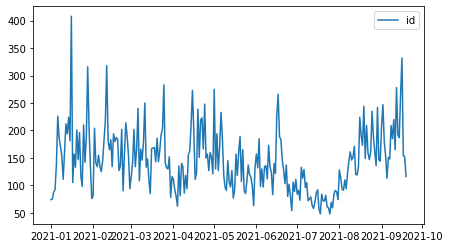

In [7]:
fig, ax = plt.subplots(figsize=(7,4))
counts = df.groupby(df.index.date)['id'].count().astype(int).to_frame()
counts.plot(ax=ax)

In [8]:
redo = True

import spacy
nlp = spacy.load('de_core_news_sm')

def lemmatize(doc):
    doc = nlp(doc)
    result = ' '.join([x.lemma_ for x in doc if not x.is_stop and not x.lemma_=="der"]) 
    return result

if redo:

    df['clean_text'] = df.text.str.replace("(?:\@|https?\://)\S+", "").str.strip()
    df['clean_text'] = df.clean_text.str.replace("&amp;","")
    df['clean_text'] = df['clean_text'].apply(lemmatize)
    
    df.to_csv('source_data/lemmatized_berlin_tweets.csv',index=False)
    
else:
    
    lem_df = pd.read_csv('source_data/lemmatized_berlin_tweets.csv',lineterminator='\n').dropna().drop(columns="lem_text")
    lem_df = lem_df.rename(columns={"text":"lem_text"})
    merged_df = df.merge(lem_df[['id',"lem_text","clean_text"]],how="outer")
    idx = (merged_df.text!=merged_df.lem_text) | (pd.isna(merged_df.lem_text))
    merged_df.loc[idx,"clean_text"] = merged_df.loc[idx].text.str.replace("(?:\@|https?\://)\S+", "").str.strip()
    merged_df.loc[idx,"clean_text"] = merged_df.loc[idx].clean_text.str.replace("&amp;","")
    merged_df.loc[idx,"clean_text"] = merged_df.loc[idx].clean_text.apply(lemmatize)
    df = merged_df
    df.to_csv('source_data/lemmatized_berlin_tweets.csv',index=False)
    
df.head()

NameError: name 'merged_df' is not defined

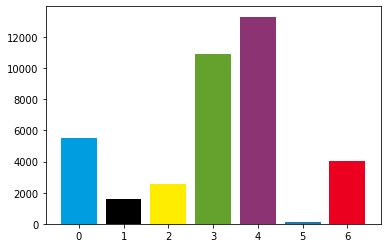

In [24]:
fig, ax = plt.subplots()
ticks = 
for i,(p, group) in enumerate(df.groupby('party')):
    ticks.append(p)
    ax.bar(i, group.shape[0],color=cdict[p.lower()])

In [10]:
# 5 What hashtags are most commonly used

from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
regex = r'\B(?!#[0-9_]+\b)(#\w{2,30})\b'

sub_df = df.reset_index()

vec =  CountVectorizer(min_df=1, token_pattern=regex)
X = vec.fit_transform(sub_df.text)
features = vec.get_feature_names()

hashtags = pd.DataFrame()
hashtags['hashtag'] = features

hashtags['total'] = np.array(X.sum(axis=0)).ravel()   

for p in df.party.unique():
    print('\n',p,'\n')
    idx = sub_df[sub_df.party==p].index
    fcounts = np.array(X[idx,:].sum(axis=0)).ravel()   
    hashtags[p] = fcounts
    sorted_counts = np.argsort(fcounts)
    for x in sorted_counts[-10:]:
        print(fcounts[x],features[x])


 LINKE 

137 #cdu
137 #linkelpt
154 #linke
218 #corona
230 #mahe
266 #recht
361 #r2g
514 #plenum
1040 #agh
1080 #berlin

 AFD 

70 #spd
70 #afghanistan
71 #cdu
82 #marzahn
87 #grüne
94 #merkel
113 #corona
114 #baerbock
213 #berlin
365 #afd

 GRUENE 

66 #verkehrswende
68 #neukoelln
83 #schnelltests
96 #neukölln
118 #allesistdrin
126 #r2g
142 #klimaschutz
217 #klargehtdas
272 #berlin
295 #corona

 SPD 

16 #ausgangssperre
16 #abgeordnetenhaus
23 #covid19
23 #r2g
27 #ganzsicherberlin
29 #wilmersdorf
30 #agh
31 #spd
33 #herzenssacheberlin
135 #berlin

 FDP 

15 #wissforscha
15 #dieseeg
16 #eurobundmeda
16 #sporta
17 #3k21
18 #r2g
18 #mietendeckel
18 #bpt21
33 #vielzutun
73 #agh

 CDUCSU 

19 #spd
20 #lockdown
21 #hohenschönhausen
26 #wk7
30 #r2g
30 #agh
37 #cdu
40 #runday
52 #corona
100 #berlin

 OTHER 

1 #eigenbedarf
1 #rechtsradikalismus
1 #beutegemeinschaft
1 #rechtsextremismus
1 #kunkel
2 #wild
3 #bosnien
4 #lockdown
29 #agh
39 #afd


In [11]:
# All hashtags
pd.options.display.max_rows = 999
hashtags.sort_values('total',ascending=False).head(500).to_csv('berlin_results/top_hashtags.csv',index=False)
hashtags.sort_values('total',ascending=False).head(10)

,hashtag,total,LINKE,AFD,GRUENE,SPD,FDP,CDUCSU,OTHER
623,#berlin,1813,1080,213,272,135,13,100,0
142,#agh,1325,1040,62,61,30,73,30,29
1141,#corona,699,218,113,295,14,6,52,1
4718,#r2g,594,361,36,126,23,18,30,0
4558,#plenum,539,514,0,22,3,0,0,0
114,#afd,472,57,365,1,2,2,6,39
1047,#cdu,307,137,71,53,7,2,37,0
3756,#mahe,289,230,1,56,2,0,0,0
4776,#recht,269,266,2,0,1,0,0,0
3198,#klargehtdas,217,0,0,217,0,0,0,0


In [12]:
# 5 What hashtags are most commonly used

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
regex = r'\b(?<!#)(\w{2,30})\b'

sub_df = df.reset_index()

vec =  TfidfVectorizer(min_df=1, token_pattern=regex,sublinear_tf=True)
vec =  CountVectorizer(min_df=1, token_pattern=regex)
term_X = vec.fit_transform(sub_df.clean_text)
term_features = vec.get_feature_names()

terms = pd.DataFrame()
terms['hashtag'] = term_features

terms['total'] = np.array(term_X.sum(axis=0)).ravel()   

for p in df.party.unique():
    print('\n',p,'\n')
    idx = sub_df[sub_df.party==p].index
    fcounts = np.array(term_X[idx,:].sum(axis=0)).ravel()   
    terms[p] = fcounts
    sorted_counts = np.argsort(fcounts)
    for x in sorted_counts[-10:]:
        print(fcounts[x],term_features[x])


 LINKE 

390 aber
544 plenum
554 mal
571 innen
656 mein
844 und
961 ts
1070 agh
1687 berlin
3012 ich

 AFD 

163 wie
169 merkel
199 wer
206 corona
303 und
354 deutschland
397 mein
406 berlin
539 afd
1129 ich

 GRUENE 

396 corona
401 mal
405 berliner
479 aber
490 danken
560 innen
656 und
673 mein
1108 berlin
2863 ich

 SPD 

127 himmeln
130 horizont
133 berliner
146 mein
165 leben
174 mal
176 und
264 gleich
415 berlin
1093 ich

 FDP 

88 sein
90 brauchen
106 mensch
108 wenn
113 jahr
143 mal
156 mein
188 und
199 berlin
780 ich

 CDUCSU 

65 berliner
71 mal
83 danken
93 jahr
97 mensch
104 und
105 cdu
176 mein
260 berlin
651 ich

 OTHER 

8 uhr
8 00
9 sein
10 berlin
15 mein
16 andrea
24 wild
28 agh
35 ich
56 afd


In [13]:
terms.sort_values('total',ascending=False).head(500).to_csv('berlin_results/top_terms.csv',index=False)
terms.sort_values('total',ascending=False).head(10)

,hashtag,total,LINKE,AFD,GRUENE,SPD,FDP,CDUCSU,OTHER
18778,ich,9563,3012,1129,2863,1093,780,651,35
5322,berlin,4085,1687,406,1108,415,199,260,10
39688,und,2273,844,303,656,176,188,104,2
25563,mein,2219,656,397,673,146,156,176,15
24965,mal,1509,554,163,401,174,143,71,3
1505,agh,1402,1070,67,93,33,81,30,28
19483,innen,1234,571,15,560,73,8,7,0
873,aber,1211,390,119,479,79,83,60,1
20087,jahr,1197,355,143,383,104,113,93,6
8305,danken,1179,376,34,490,117,78,83,1


In [14]:
# 5 What hashtags are most commonly used

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
regex = r'\b(?<!#)(\w{2,30})\b'

sub_df = df.reset_index()

vec =  TfidfVectorizer(min_df=1, token_pattern=regex,sublinear_tf=True)
vec =  CountVectorizer(min_df=1, token_pattern=regex, ngram_range=(2,2))
bigram_X = vec.fit_transform(sub_df.clean_text)
bigram_features = vec.get_feature_names()

bigrams = pd.DataFrame()
bigrams['hashtag'] = bigram_features

bigrams['total'] = np.array(bigram_X.sum(axis=0)).ravel()   

for p in df.party.unique():
    print('\n',p,'\n')
    idx = sub_df[sub_df.party==p].index
    fcounts = np.array(bigram_X[idx,:].sum(axis=0)).ravel()   
    bigrams[p] = fcounts
    sorted_counts = np.argsort(fcounts)
    for x in sorted_counts[-10:]:
        print(fcounts[x],bigram_features[x])


 LINKE 

95 herzliche glückwunsch
122 mein ines
171 plenum berlin
179 plenum ts
185 recht berlin
186 agh plenum
192 agh recht
195 berlin plenum
306 berlin ts
358 agh berlin

 AFD 

22 so genannt
24 mein kind
26 ich mal
29 afd infostand
34 ich brauchen
36 september afd
40 26 september
41 berlin marzahn
45 afd wählen
47 herzliche dank

 GRUENE 

38 neukölln neukoelln
39 ich hoffen
39 kein vergessen
41 mieter innen
42 guten morgen
55 ich finden
57 berliner innen
79 ich freuen
88 herzliche glückwunsch
98 ich brauchen

 SPD 

29 berliner innen
30 isenberg mda
33 haben foto
33 foto gepostet
37 thoma isenberg
127 himmeln gleich
127 gleich himmeln
127 leben gleich
128 gleich horizont
130 ich leben

 FDP 

14 wissforscha agh
16 viel erfolgen
16 eurobundmeda agh
16 sporta agh
17 viel dank
20 ich mal
21 ich freuen
25 zum beispiel
29 ich brauchen
30 herzliche glückwunsch

 CDUCSU 

11 ich wünsche
11 herzliche glückwunsch
11 wannsee zehlendorf
12 berlin cdu
12 in berlin
14 ich brauchen
15 ich mein

In [15]:
bigrams.sort_values('total',ascending=False).head(500).to_csv('berlin_results/top_bigrams.csv',index=False)
bigrams.sort_values('total',ascending=False).head(50)

,hashtag,total,LINKE,AFD,GRUENE,SPD,FDP,CDUCSU,OTHER
8523,agh berlin,380,358,13,4,2,1,1,1
30646,berlin ts,306,306,0,0,0,0,0,0
106904,ich brauchen,279,90,34,98,14,29,14,0
101877,herzliche glückwunsch,249,95,8,88,17,30,11,0
30339,berlin plenum,195,195,0,0,0,0,0,0
8681,agh recht,192,192,0,0,0,0,0,0
107393,ich freuen,191,55,3,79,24,21,9,0
8670,agh plenum,190,186,0,4,0,0,0,0
179413,recht berlin,186,185,0,0,0,0,1,0
171658,plenum ts,179,179,0,0,0,0,0,0


In [16]:
term_topics = pd.read_excel('data/woerter_und_hashtags_v3.xlsx')
term_topics.head()

,hashtag,topic,Unnamed: 2
0,bundestag,politik-intern,NaN
1,corona,corona,NaN
2,cdu,parteien,NaN
3,danken,zusammenhalt,NaN
4,afd,parteien,NaN


In [17]:
topics = []
for topic, group in term_topics.groupby('topic'):
    topics.append(topic)
    df[topic]=0
    cloc = df.columns.get_loc(topic)
    for term in group.hashtag.unique():
        term = str(term)
        if "#" in term:
            x = X
            feat = features
        else:
            x = term_X
            feat = term_features
            term_id = np.argwhere(np.array(feat)==term).ravel()
            idx = x[:,term_id].nonzero()[0] 
            df.iloc[idx,cloc] = 1

In [18]:
topic_ds = [
    {"name":"digitales","keywords":[
        "digital\w* *bildung",
        "digital\w* *verwaltung",
        "^(?=.*5g)(?!.*(impf|covid|pandemie|corona)).*",
        "automatisier(en|t|ung)",
        "digitale\w* *\w*ämt"
    ]},
    {"name":"verkehr","keywords": ["^(?=.*auto)(?!.*matisier).*",]},
    {"name": "arbeit", "keywords": ["beruf(?!en)"]},
    {"name": "außenpolitik", "keywords": ["vereint\w* *nationen","(?<!ent)rüstung"]},
    {"name": "familien", "keywords": ["^(?=.*familien)(?!.*(angehörige|opfer)).*"]},
    {"name": "wohnen", "keywords": ["bauen\W*bauen\W*bauen"]},
    {"name": "gewalt", "keywords": ["^(?=.*gewalt)(?!.*(vierte|dritte)).*"]}
]
topic_names = []
redo = True
for t in topic_ds:
    print(t)
    if t["name"] not in topics:
        topics.append(t["name"])
    for term in t["keywords"]:
        df.loc[df['text'].str.lower().str.contains(term.lower()),t["name"]] = 1

df.head()

{'name': 'digitales', 'keywords': ['digital\\w* *bildung', 'digital\\w* *verwaltung', '^(?=.*5g)(?!.*(impf|covid|pandemie|corona)).*', 'automatisier(en|t|ung)', 'digitale\\w* *\\w*ämt']}


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


{'name': 'verkehr', 'keywords': ['^(?=.*auto)(?!.*matisier).*']}
{'name': 'arbeit', 'keywords': ['beruf(?!en)']}
{'name': 'außenpolitik', 'keywords': ['vereint\\w* *nationen', '(?<!ent)rüstung']}
{'name': 'familien', 'keywords': ['^(?=.*familien)(?!.*(angehörige|opfer)).*']}
{'name': 'wohnen', 'keywords': ['bauen\\W*bauen\\W*bauen']}
{'name': 'gewalt', 'keywords': ['^(?=.*gewalt)(?!.*(vierte|dritte)).*']}


,id,text,author_id,region,party,parltype,"Name, Vorname",Twitter-Name,clean_text,0,...,sozialpolitik,staat,verkehr,wahlen,wirtschaft,wissenschaft,wohnen,zukunft,zusammenhalt,familien
created_at,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:01:02+00:00,1344795732142911490,@a_kallies Das wünsche ich Ihnen auch. 2021 ka...,38167665,Berlin,LINKE,Land,"Schlüsselburg, Sebastian",@schluesselburg,wünsche ich . 2021 .,0,...,0,0,0,0,0,0,0,0,0,NaN
2021-01-01 00:21:08+00:00,1344800790637137921,Habe in meiner Nachbarschaft bisher keinen Unt...,2815311985,Berlin,AFD,Land,"Weiß, Thorsten",@WeissAfD,haben Nachbarschaft Unterschied Böllern vergle...,0,...,0,0,0,0,0,0,0,0,0,NaN
2021-01-01 00:24:19+00:00,1344801591124230144,"@CosGla Danke, auf ein Neues!",715144643390914560,Berlin,LINKE,Land,"Kittler, Regina",@regina_kittler,"danken , Neues !",0,...,0,0,0,0,0,0,0,0,1,NaN
2021-01-01 00:35:12+00:00,1344804332429049859,Mein Rückblick auf die wenige erlebte Kultur 2...,715144643390914560,Berlin,LINKE,Land,"Kittler, Regina",@regina_kittler,mein Rückblick erleben Kultur 2020 - danken ! ...,0,...,0,0,0,0,0,0,0,0,1,NaN
2021-01-01 00:39:27+00:00,1344805401288708096,@kulturprojekteb @deutsche_oper @TheaterStrahl,715144643390914560,Berlin,LINKE,Land,"Kittler, Regina",@regina_kittler,,0,...,0,0,0,0,0,0,0,0,0,NaN


In [23]:
df.to_csv('source_data/ht_term_annotated_tweets_berlin.csv',index=False)

In [20]:
cdict = {'afd': '#009EE0',
 'bp': None,
 'cducsu': '#000000',
 'dp': None,
 'drp': None,
 'dzp': None,
 'fdp': '#FFED00',
 'fraktionslos': None,
 'gb/bhe': None,
 'gruene': '#64A12D',
 'kpd': None,
 'linke': '#8C3473',
 'other': None,
 'parteilos': None,
 'pds': None,
 'spd': '#EB001F',
 'wav': None}

In [21]:
# if type(df.index) == pd.core.indexes.numeric.Int64Index:
#     df_times = pd.read_csv('~/Documents/papers/iass-mcc-twitter-colab/data/all_tweets.csv',lineterminator='\n')
#     df_times['created_at'] = pd.to_datetime(df_times['created_at'])
#     df = df.merge(df_times[['id','created_at']])
#     df = df.set_index("created_at")
    
# df.head()

#####
#####
 14
#####
#####
Minimum periods:  14
0
mentioned  7796  times
?
mentioned  16  times
agrar
mentioned  3  times
arbeit
mentioned  600  times
außenpolitik
mentioned  554  times
bildung
mentioned  814  times
bürokratie
mentioned  138  times
corona
mentioned  2461  times


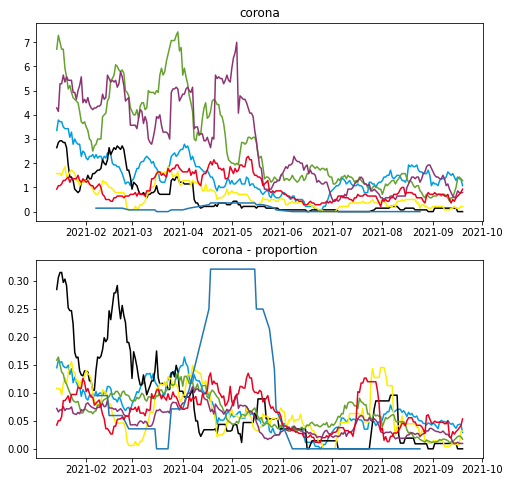

debatte
mentioned  2200  times
digitales
mentioned  167  times
diskriminierung
mentioned  305  times
einfamilienhaus
mentioned  15  times
emotion
mentioned  155  times
engagement
mentioned  142  times
erinnerung
mentioned  139  times
europa
mentioned  235  times
familie
mentioned  660  times
freiheit
mentioned  153  times
gesellschaft
mentioned  185  times
gewalt
mentioned  234  times
gleichberechtigung
mentioned  64  times
internationales
mentioned  10  times
klima
mentioned  644  times


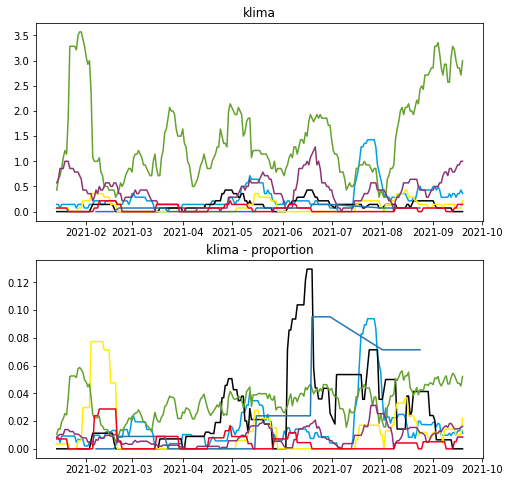

korruption
mentioned  30  times
medien
mentioned  280  times
menschenrechte
mentioned  43  times
migration
mentioned  143  times
parteien
mentioned  3426  times
politik-intern
mentioned  3512  times
politiker
mentioned  647  times
recht
mentioned  279  times
religion
mentioned  100  times
rente
mentioned  29  times
sicherheit
mentioned  315  times
sozialpolitik
mentioned  458  times
staat
mentioned  1388  times
verkehr
mentioned  732  times
wahlen
mentioned  740  times


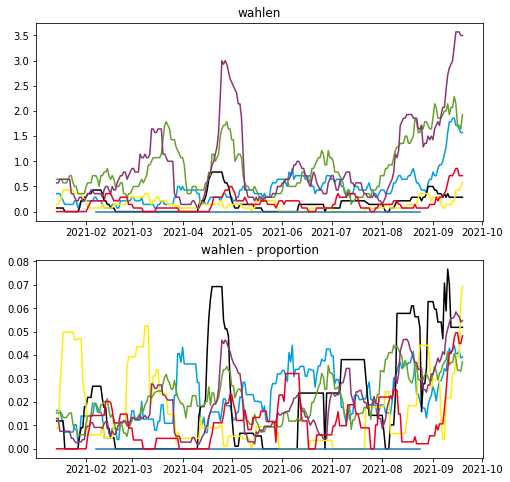

wirtschaft
mentioned  1418  times
wissenschaft
mentioned  64  times
wohnen
mentioned  867  times


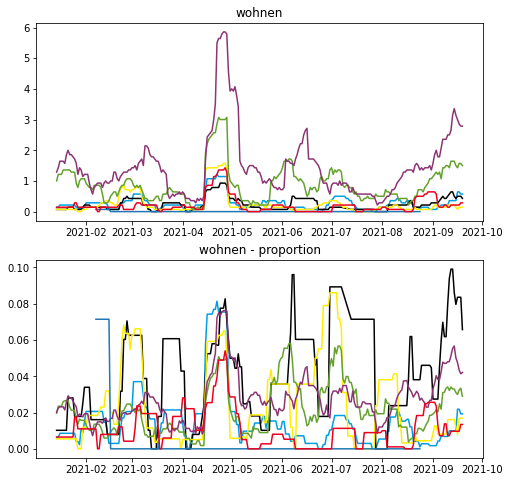

zukunft
mentioned  272  times
zusammenhalt
mentioned  2594  times
familien
mentioned  175  times
#####
#####
 14
#####
#####
Minimum periods:  7
0
mentioned  7796  times
?
mentioned  16  times
agrar
mentioned  3  times
arbeit
mentioned  600  times
außenpolitik
mentioned  554  times
bildung
mentioned  814  times
bürokratie
mentioned  138  times
corona
mentioned  2461  times


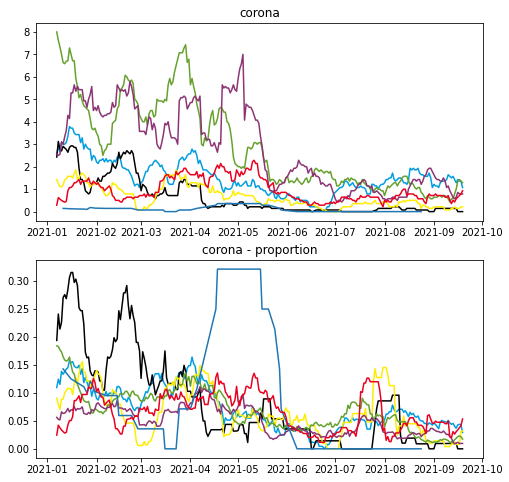

debatte
mentioned  2200  times
digitales
mentioned  167  times
diskriminierung
mentioned  305  times
einfamilienhaus
mentioned  15  times
emotion
mentioned  155  times
engagement
mentioned  142  times
erinnerung
mentioned  139  times
europa
mentioned  235  times
familie
mentioned  660  times
freiheit
mentioned  153  times
gesellschaft
mentioned  185  times
gewalt
mentioned  234  times
gleichberechtigung
mentioned  64  times
internationales
mentioned  10  times
klima
mentioned  644  times


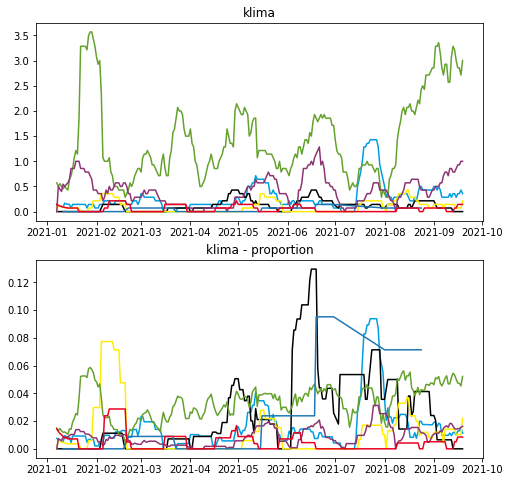

korruption
mentioned  30  times
medien
mentioned  280  times
menschenrechte
mentioned  43  times
migration
mentioned  143  times
parteien
mentioned  3426  times
politik-intern
mentioned  3512  times
politiker
mentioned  647  times
recht
mentioned  279  times
religion
mentioned  100  times
rente
mentioned  29  times
sicherheit
mentioned  315  times
sozialpolitik
mentioned  458  times
staat
mentioned  1388  times
verkehr
mentioned  732  times
wahlen
mentioned  740  times


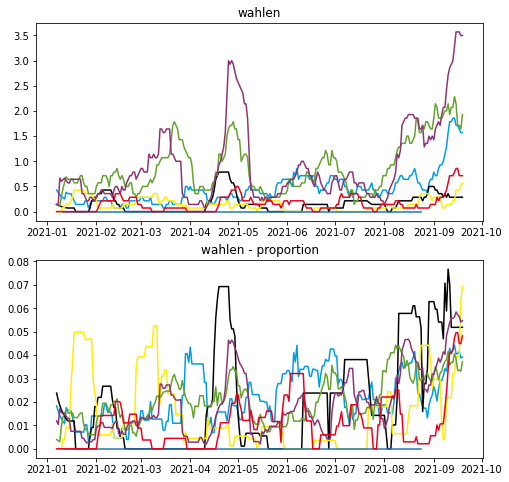

wirtschaft
mentioned  1418  times
wissenschaft
mentioned  64  times
wohnen
mentioned  867  times


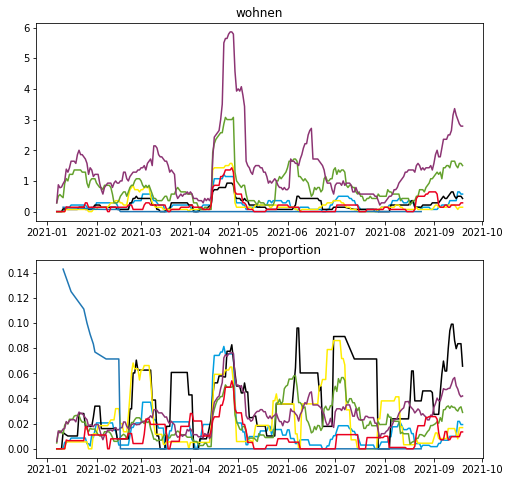

zukunft
mentioned  272  times
zusammenhalt
mentioned  2594  times
familien
mentioned  175  times
#####
#####
 30
#####
#####
Minimum periods:  30
0
mentioned  7796  times
?
mentioned  16  times
agrar
mentioned  3  times
arbeit
mentioned  600  times
außenpolitik
mentioned  554  times
bildung
mentioned  814  times
bürokratie
mentioned  138  times
corona
mentioned  2461  times


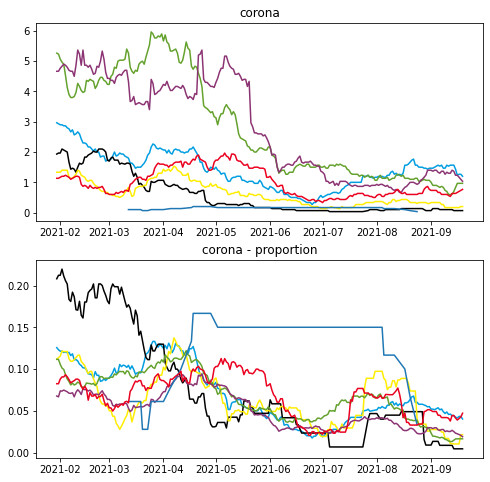

debatte
mentioned  2200  times
digitales
mentioned  167  times
diskriminierung
mentioned  305  times
einfamilienhaus
mentioned  15  times
emotion
mentioned  155  times
engagement
mentioned  142  times
erinnerung
mentioned  139  times
europa
mentioned  235  times
familie
mentioned  660  times
freiheit
mentioned  153  times
gesellschaft
mentioned  185  times
gewalt
mentioned  234  times
gleichberechtigung
mentioned  64  times
internationales
mentioned  10  times
klima
mentioned  644  times


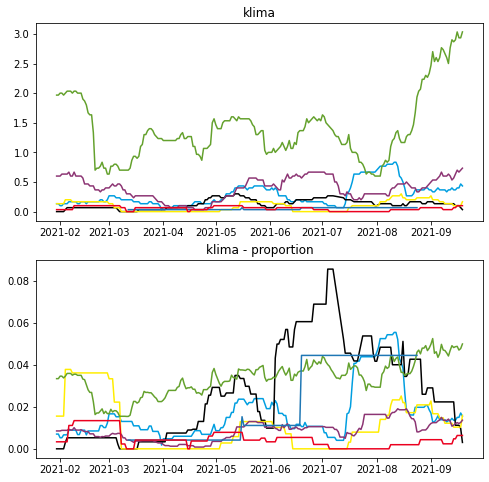

korruption
mentioned  30  times
medien
mentioned  280  times
menschenrechte
mentioned  43  times
migration
mentioned  143  times
parteien
mentioned  3426  times
politik-intern
mentioned  3512  times
politiker
mentioned  647  times
recht
mentioned  279  times
religion
mentioned  100  times
rente
mentioned  29  times
sicherheit
mentioned  315  times
sozialpolitik
mentioned  458  times
staat
mentioned  1388  times
verkehr
mentioned  732  times
wahlen
mentioned  740  times


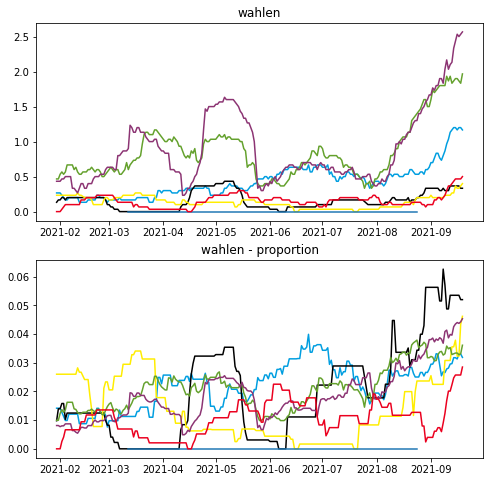

wirtschaft
mentioned  1418  times
wissenschaft
mentioned  64  times
wohnen
mentioned  867  times


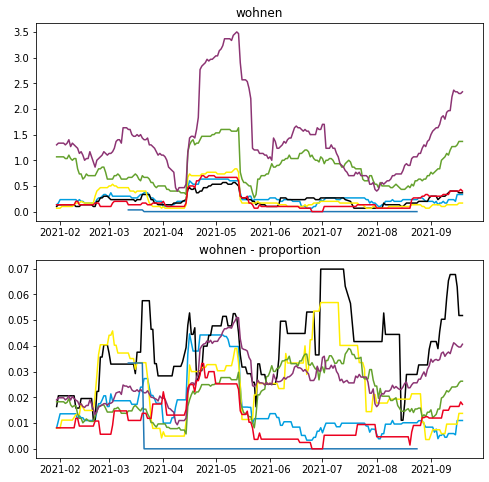

zukunft
mentioned  272  times
zusammenhalt
mentioned  2594  times
familien
mentioned  175  times
#####
#####
 30
#####
#####
Minimum periods:  7
0
mentioned  7796  times
?
mentioned  16  times
agrar
mentioned  3  times
arbeit
mentioned  600  times
außenpolitik
mentioned  554  times
bildung
mentioned  814  times
bürokratie
mentioned  138  times
corona
mentioned  2461  times


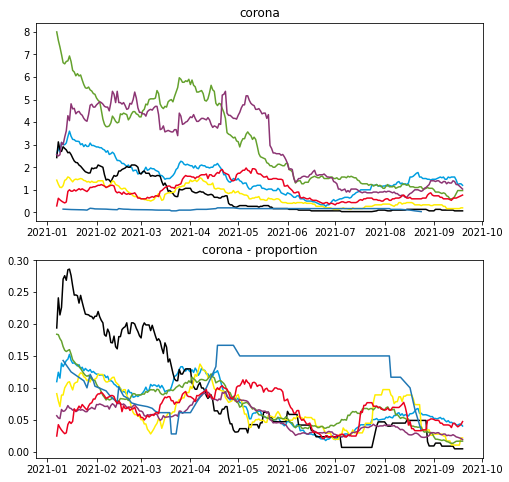

debatte
mentioned  2200  times
digitales
mentioned  167  times
diskriminierung
mentioned  305  times
einfamilienhaus
mentioned  15  times
emotion
mentioned  155  times
engagement
mentioned  142  times
erinnerung
mentioned  139  times
europa
mentioned  235  times
familie
mentioned  660  times
freiheit
mentioned  153  times
gesellschaft
mentioned  185  times
gewalt
mentioned  234  times
gleichberechtigung
mentioned  64  times
internationales
mentioned  10  times
klima
mentioned  644  times


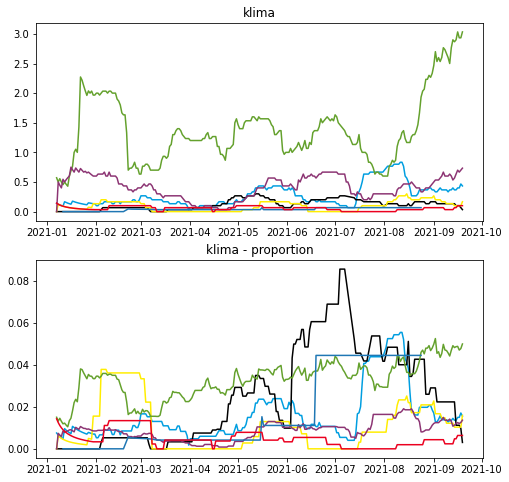

korruption
mentioned  30  times
medien
mentioned  280  times
menschenrechte
mentioned  43  times
migration
mentioned  143  times
parteien
mentioned  3426  times
politik-intern
mentioned  3512  times
politiker
mentioned  647  times
recht
mentioned  279  times
religion
mentioned  100  times
rente
mentioned  29  times
sicherheit
mentioned  315  times
sozialpolitik
mentioned  458  times
staat
mentioned  1388  times
verkehr
mentioned  732  times
wahlen
mentioned  740  times


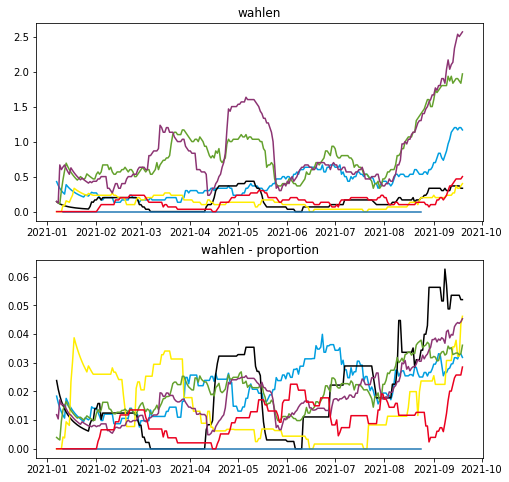

wirtschaft
mentioned  1418  times
wissenschaft
mentioned  64  times
wohnen
mentioned  867  times


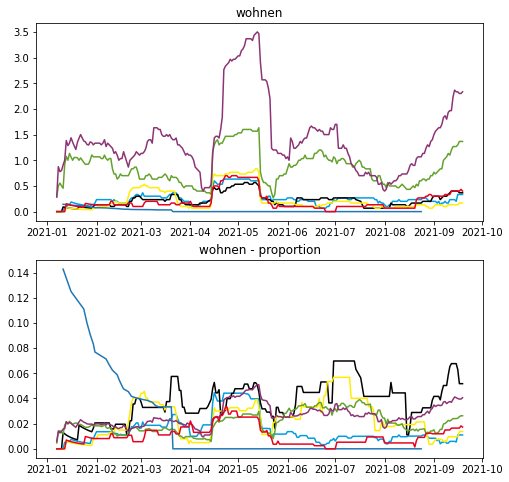

zukunft
mentioned  272  times
zusammenhalt
mentioned  2594  times
familien
mentioned  175  times
#####
#####
 60
#####
#####
Minimum periods:  60
0
mentioned  7796  times
?
mentioned  16  times
agrar
mentioned  3  times
arbeit
mentioned  600  times
außenpolitik
mentioned  554  times
bildung
mentioned  814  times
bürokratie
mentioned  138  times
corona
mentioned  2461  times


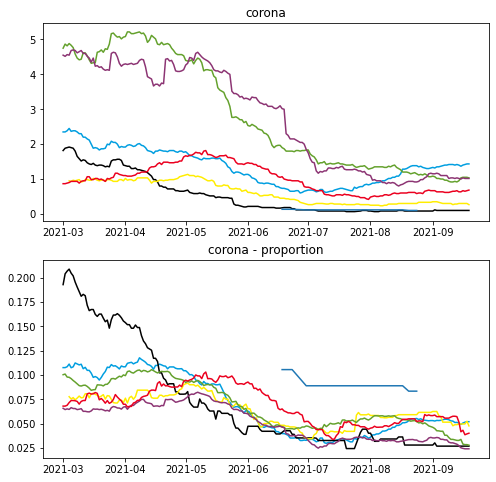

debatte
mentioned  2200  times
digitales
mentioned  167  times
diskriminierung
mentioned  305  times
einfamilienhaus
mentioned  15  times
emotion
mentioned  155  times
engagement
mentioned  142  times
erinnerung
mentioned  139  times
europa
mentioned  235  times
familie
mentioned  660  times
freiheit
mentioned  153  times
gesellschaft
mentioned  185  times
gewalt
mentioned  234  times
gleichberechtigung
mentioned  64  times
internationales
mentioned  10  times
klima
mentioned  644  times


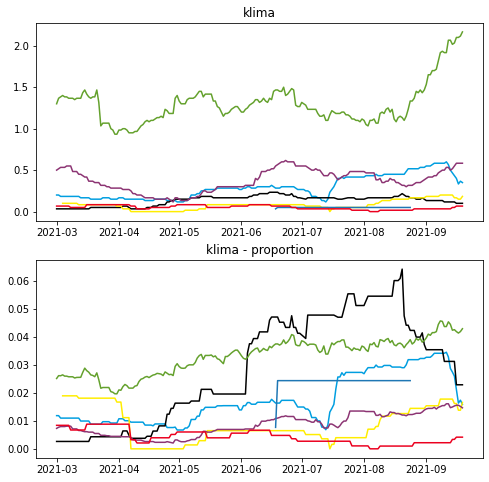

korruption
mentioned  30  times
medien
mentioned  280  times
menschenrechte
mentioned  43  times
migration
mentioned  143  times
parteien
mentioned  3426  times
politik-intern
mentioned  3512  times
politiker
mentioned  647  times
recht
mentioned  279  times
religion
mentioned  100  times
rente
mentioned  29  times
sicherheit
mentioned  315  times
sozialpolitik
mentioned  458  times
staat
mentioned  1388  times
verkehr
mentioned  732  times
wahlen
mentioned  740  times


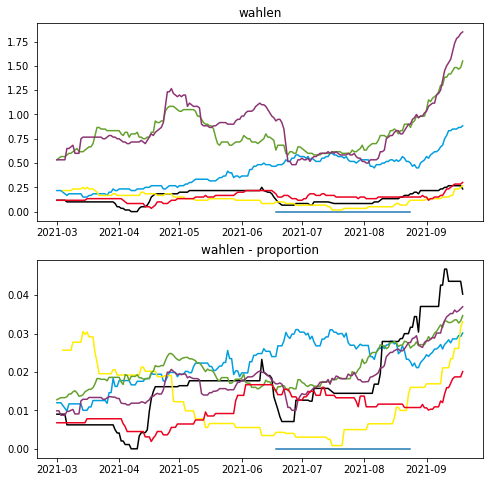

wirtschaft
mentioned  1418  times
wissenschaft
mentioned  64  times
wohnen
mentioned  867  times


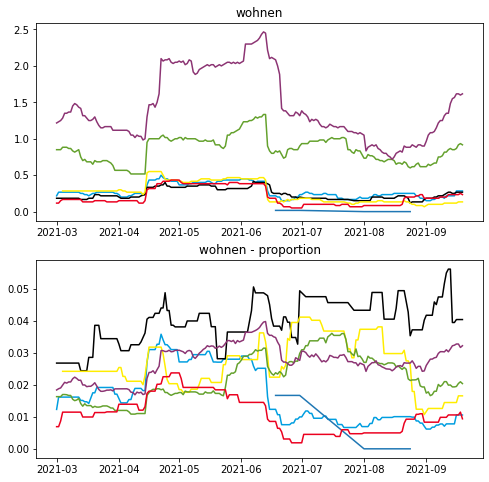

zukunft
mentioned  272  times
zusammenhalt
mentioned  2594  times
familien
mentioned  175  times
#####
#####
 60
#####
#####
Minimum periods:  7
0
mentioned  7796  times
?
mentioned  16  times
agrar
mentioned  3  times
arbeit
mentioned  600  times
außenpolitik
mentioned  554  times
bildung
mentioned  814  times
bürokratie
mentioned  138  times
corona
mentioned  2461  times


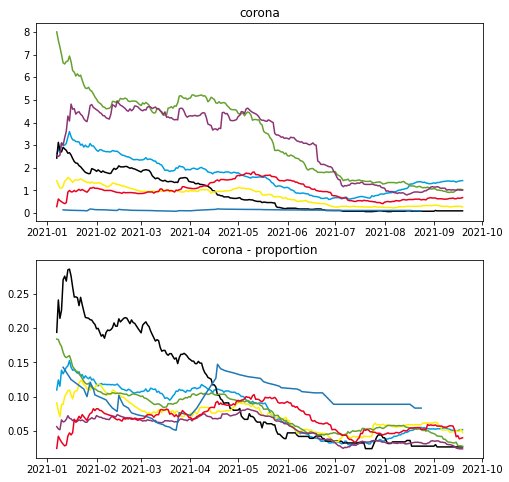

debatte
mentioned  2200  times
digitales
mentioned  167  times
diskriminierung
mentioned  305  times
einfamilienhaus
mentioned  15  times
emotion
mentioned  155  times
engagement
mentioned  142  times
erinnerung
mentioned  139  times
europa
mentioned  235  times
familie
mentioned  660  times
freiheit
mentioned  153  times
gesellschaft
mentioned  185  times
gewalt
mentioned  234  times
gleichberechtigung
mentioned  64  times
internationales
mentioned  10  times
klima
mentioned  644  times


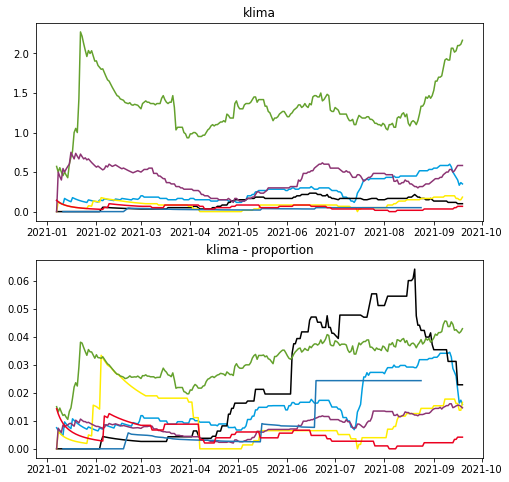

korruption
mentioned  30  times
medien
mentioned  280  times
menschenrechte
mentioned  43  times
migration
mentioned  143  times
parteien
mentioned  3426  times
politik-intern
mentioned  3512  times
politiker
mentioned  647  times
recht
mentioned  279  times
religion
mentioned  100  times
rente
mentioned  29  times
sicherheit
mentioned  315  times
sozialpolitik
mentioned  458  times
staat
mentioned  1388  times
verkehr
mentioned  732  times
wahlen
mentioned  740  times


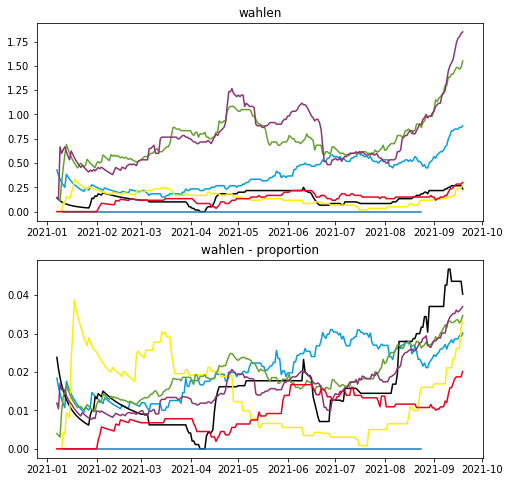

wirtschaft
mentioned  1418  times
wissenschaft
mentioned  64  times
wohnen
mentioned  867  times


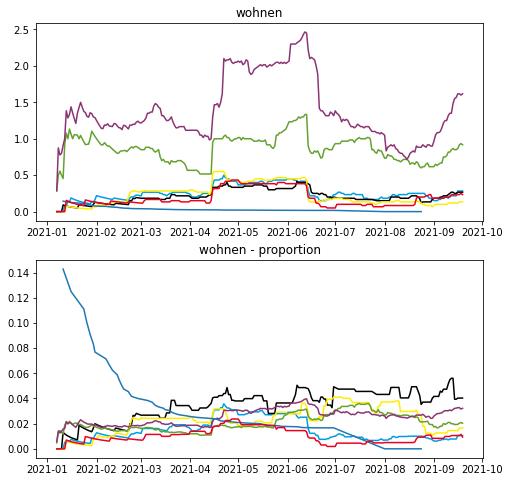

zukunft
mentioned  272  times
zusammenhalt
mentioned  2594  times
familien
mentioned  175  times


In [22]:

for days in [14,30,60]:
    
    for min_periods in [days,7]:

        print("#####\n#####\n",days)
        
        print("#####\n#####\nMinimum periods: ", min_periods,)
        for j,c in enumerate(topics):

            print(c)

            sub_df = df[df[c]==1].reset_index()

            print("mentioned ", sub_df.shape[0], " times")
            if not os.path.isdir(f"berlin_results/{c}"):
                os.mkdir(f"berlin_results/{c}")

            regex = r'\B(?!#[0-9_]+\b)(#\w{2,30})\b'

            vec =  CountVectorizer(min_df=1, token_pattern=regex)
            X = vec.fit_transform(sub_df.text)
            features = vec.get_feature_names()

            hashtags = pd.DataFrame()
            hashtags['hashtag'] = features

            hashtags['total'] = np.array(X.sum(axis=0)).ravel()   

            for p in df.party.unique():
                idx = sub_df[sub_df.party==p].index
                fcounts = np.array(X[idx,:].sum(axis=0)).ravel()   
                hashtags[p] = fcounts
                sorted_counts = np.argsort(fcounts)

            hashtags.sort_values('total',ascending=False).head(500).to_csv(f'berlin_results/{c}/top_hashtags.csv',index=False)

            regex = r'\b(?<!#)(\w{2,30})\b'

            vec =  CountVectorizer(min_df=1, token_pattern=regex)
            term_X = vec.fit_transform(sub_df.clean_text)
            term_features = vec.get_feature_names()

            terms = pd.DataFrame()
            terms['hashtag'] = term_features

            terms['total'] = np.array(term_X.sum(axis=0)).ravel()   

            for p in df.party.unique():
                idx = sub_df[sub_df.party==p].index
                fcounts = np.array(term_X[idx,:].sum(axis=0)).ravel()   
                terms[p] = fcounts
                sorted_counts = np.argsort(fcounts)

            terms.sort_values('total',ascending=False).head(500).to_csv(f'berlin_results/{c}/top_terms.csv',index=False)

            fig, axs = plt.subplots(2, figsize=(8,8))

            count_df = pd.DataFrame()

            ax = axs[0]
            for party, group in df.groupby('party'):
                counts = group.groupby(group.index.date)[c].sum()
                counts = counts.rolling(days, min_periods=min_periods).mean()
                count_df = count_df.merge(counts.to_frame(party),left_index=True, right_index=True,how="outer")
                ax.plot(counts, color=cdict[party.lower()])

            ax.set_title(c)

            ax = axs[1]
            for party, group in df.groupby('party'):
                counts = group.groupby(group.index.date)[c].sum() / group.groupby(group.index.date)[c].count()
                counts = counts.rolling(days, min_periods=min_periods).mean()
                count_df = count_df.merge(counts.to_frame(f"{party} - norm"),left_index=True, right_index=True,how="outer")
                ax.plot(counts, color=cdict[party.lower()])

            ax.set_title(f"{c} - proportion")

            plt.savefig(f"berlin_results/{c}/topic_over_time_{days}_days_{min_periods}_minimum_days.png",bbox_inches="tight")
            count_df.to_csv(f"berlin_results/{c}/counts_{days}_days_{min_periods}_minimum_days.csv")

            if c in ["klima","corona","wohnen","wahlen"]:
                plt.show()
            else:
                plt.close()


In [25]:
sub_df = df[(df['klima']==1)&(df['party']=="GRUENE") & (df.index.date>datetime.date(2021,9,1))]
sub_df.groupby(sub_df.index.date)['id'].count()

2021-09-02    12
2021-09-03     9
2021-09-04    16
2021-09-05    15
2021-09-06    12
2021-09-07    46
2021-09-08    15
2021-09-09    13
2021-09-10    19
2021-09-11    12
2021-09-12    58
2021-09-13    18
2021-09-14    17
2021-09-15    10
2021-09-16    15
2021-09-17    13
2021-09-18     7
2021-09-19    29
Name: id, dtype: int64

In [26]:
sub_df.head().text.values

array(['So ist es, deshalb wollen auch wir @Die_Gruenen den CO2-Preis dort erheben wo die größte Lenkungswirkung erzieht wird - beim Eigentümer. https://t.co/s2oLfHhtAE',
       '„#Klimaschutz wird aus Schrott gemacht“ 😉 https://t.co/1WeOzz61pa\nGute Gespräche in München mit der Stahlrecyclingindustrie #Kreislaufwirtschaft https://t.co/eN56EMFuYC',
       'EINLADUNG zum digitalen Feierabend am 08.09.2021 um 20:00Uhr\n\nKlimaschutz vom Acker bis zum Teller \nWie gelingen Agrar- und Ernährungswende? \nMit @HofstetGP &amp; @DrTurgutAltug \n\nAlle Infos gibt es auf https://t.co/wMish4jKc7  oder "drüben" bei Facebook:\nhttps://t.co/gZlXvc0PP5 \n/TK https://t.co/p3HLPGz34r',
       'Wir haben einen Plan für konsequenten Klimaschutz, mehr Gerechtigkeit &amp; Zukunft. Diese Bundestagswahl ist eine Richtungsentscheidung. Es geht um ein "Weiter so" mit Armin Laschet &amp; Olaf Scholz oder einen Aufbruch mit Annalena Baerbock, Robert Habeck &amp; starken @Die_Gruenen. https://t.co/ikbNq05gRy',
  

In [27]:
ignore_topics = [
    "politik-intern","debatte","emotion","einfamilienhaus",
    "parteien","politiker","staat","zukunft","0","?"
]

results = []
for j,c in enumerate(topics):
    if c in ignore_topics:
        continue
    topic_sum = df[c].sum()
    for party, pgroup in df.groupby('party'):
    
        results.append({
            "party":party,"topic":c,"n":pgroup[c].sum(),"topic_sum":topic_sum,
            "party_sum": pgroup.shape[0]
        })

topic_sums = pd.DataFrame.from_dict(results).sort_values('topic_sum').reset_index(drop=True)
topic_sums.to_csv('berlin_results/topic_sums.csv',index=False)
topic_sums.head()

,party,topic,n,topic_sum,party_sum
0,FDP,agrar,5.0,72.0,29091
1,SPD,agrar,6.0,72.0,30496
2,LINKE,agrar,13.0,72.0,34417
3,AFD,agrar,13.0,72.0,16536
4,CDUCSU,agrar,22.0,72.0,24998


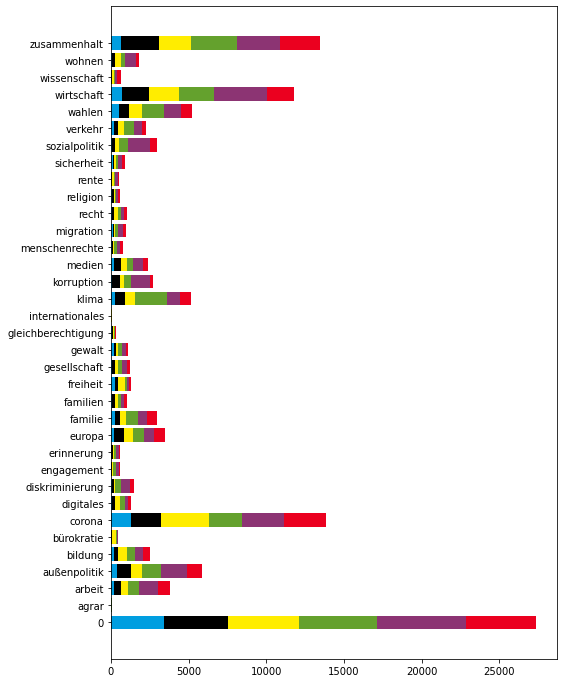

In [28]:
fig, ax = plt.subplots(figsize=(8,12))

ticks = []
for i, (name, group) in enumerate(topic_sums.groupby("topic")):
    left = 0
    for party, pgroup in group.groupby('party'):
        x = pgroup.n.values[0]
        ax.barh(i,x,color=cdict[party.lower()], left=left)
        left+=x
    ticks.append(name)
        
ax.set_yticks(range(len(ticks)))
ax.set_yticklabels(ticks)

plt.show()

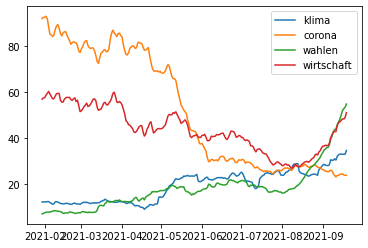

In [29]:
sub_topics = ["klima","corona","wahlen","wirtschaft"]

fig, ax = plt.subplots()

count_df = pd.DataFrame()

for c in sub_topics:
    counts = df.groupby(df.index.date)[c].sum()
    counts = counts.rolling(30).mean()
    count_df = count_df.merge(counts.to_frame(c),left_index=True, right_index=True,how="outer")
    ax.plot(counts, label=c)
    
ax.legend()

count_df.to_csv('berlin_results/comparison.csv')

plt.show()

In [30]:
group

,party,topic,n,topic_sum,party_sum
192,CDUCSU,zusammenhalt,2440.0,13435.0,24998
193,SPD,zusammenhalt,2523.0,13435.0,30496
194,LINKE,zusammenhalt,2791.0,13435.0,34417
195,GRUENE,zusammenhalt,2958.0,13435.0,31799
196,FDP,zusammenhalt,2088.0,13435.0,29091
197,AFD,zusammenhalt,635.0,13435.0,16536


In [31]:
cases = pd.read_excel('data/Fallzahlen_Kum_Tab.xlsx',sheet_name="BL_7-Tage-Fallzahlen (fixiert)",skiprows=2)
cases = cases.rename(columns={"Unnamed: 0":"Land"})
cases = cases[cases["Land"]=="Gesamt"]

cases = cases[cases.columns[1:]].melt(var_name="date")

cases.head()

,date,value
0,2020-05-06,5980
1,2020-05-07,5705
2,2020-05-08,5394
3,2020-05-09,5703
4,2020-05-10,5715


In [ ]:
cases.columns[1:]

In [ ]:
cases.tail()